In [115]:
using Random, GMRF

include("src/dataGen.jl");
include("src/utils.jl");
include("src/model.jl");
include("src/monteCarlo.jl");
include("src/mcmc.jl");
include("src/plotting.jl");

Taille de la grille (à ne pas modifier)

In [116]:
M₁ = 3;
M₂ = 3;
M = M₁ * M₂;

- Génération de la grille cible
- Création des données artificielles

In [117]:
Random.seed!(300);
Fmu = iGMRF(M₁, M₂, 1, 10);
Fphi = iGMRF(M₁, M₂, 1, 100);
Fxi = iGMRF(M₁, M₂, 1, 100000);
gridTarget = generateTargetGrid(Fmu, Fphi, Fxi);
gridTarget[:, :, 1] = gridTarget[:, :, 1] .+ 10.0;
gridTarget[:, :, 2] = gridTarget[:, :, 2] .+ 1.0;
gridTarget[:, :, 3] = gridTarget[:, :, 3] .+ .3;
nobs = 100;
data = generateData(gridTarget, nobs);

Réglages de CAVI

In [118]:
nEpoch = 100;

Structure de stockage des traces

In [119]:
muMeanTrace = zeros(M, nEpoch);
phiMeanTrace = zeros(M, nEpoch);
xiMeanTrace = zeros(M, nEpoch);
varTrace = zeros(M, nEpoch, 9);
MCKL = [];

Initialisation  
On a seulement besoin d'initialiser les m  
Ceux-ci peuvent être initialisés à 0 -> on n'y touche pas

In [120]:
using ForwardDiff

for k = 1:nEpoch
    if k > 1
        approxMarginals = Vector{Distribution}();
        muMeanTrace[:, k] = muMeanTrace[:, k-1];
        phiMeanTrace[:, k] = phiMeanTrace[:, k-1];
        xiMeanTrace[:, k] = xiMeanTrace[:, k-1];
        for i = 1:M
            μ̄i = neighborsMean(i, muMeanTrace[:, k], Fmu);
            ϕ̄i = neighborsMean(i, phiMeanTrace[:, k], Fphi);
            ξ̄i = neighborsMean(i, xiMeanTrace[:, k], Fxi);
            g(θi::DenseVector) = logfullconditional(
                i,
                θi,
                μ̄i=μ̄i,
                ϕ̄i=ϕ̄i,
                ξ̄i=ξ̄i,
                Fmu=Fmu,
                Fphi=Fphi,
                Fxi=Fxi,
                data=data,
            );
            (muMeanTrace[i, k], phiMeanTrace[i, k], xiMeanTrace[i, k]) = findMode(
                θi -> g(θi),
                [muMeanTrace[i, k], phiMeanTrace[i, k], xiMeanTrace[i, k]],
            );
            varTrace[i, k, :] = round.(
                flatten(fisherVar(
                    θi -> g(θi),
                    [muMeanTrace[i, k], phiMeanTrace[i, k], xiMeanTrace[i, k]],
                )),
                digits = 7,
            );
            push!(
                approxMarginals,
                MvNormal(
                    [muMeanTrace[i, k], phiMeanTrace[i, k], xiMeanTrace[i, k]],
                    vecToMatrix(varTrace[i, k, :]),
                ),
            );
        end
        logtarget(θ::DenseVector) = logposterior(θ, Fmu=Fmu, Fphi=Fphi, Fxi=Fxi, data=data);
        push!(MCKL, MonteCarloKL(logtarget, approxMarginals));
    end
end

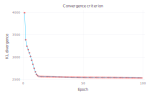

In [121]:
plotConvergenceCriterion(MCKL)

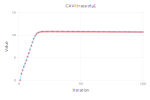

In [122]:
plotTraceCAVI(muMeanTrace[1, :], "μ1")

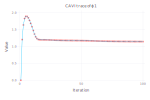

In [123]:
plotTraceCAVI(phiMeanTrace[1, :], "ϕ1")

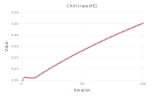

In [124]:
plotTraceCAVI(xiMeanTrace[1, :], "ξ1")

In [125]:
gridTarget

3×3×3 Array{Float64, 3}:
[:, :, 1] =
 10.3547   10.3817    9.99082
  9.86991   9.8917   10.0787
 10.0797    9.66416   9.68869

[:, :, 2] =
 1.02426   0.971222  1.16817
 0.92435   0.924401  1.13091
 0.930856  0.921579  1.00425

[:, :, 3] =
 0.299329  0.299976  0.298913
 0.299674  0.298036  0.297938
 0.302127  0.303741  0.300266

In [126]:
reshape(muMeanTrace[:, end], (3, 3))'

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 10.6808  10.549   10.1833
 10.5665  10.5293  10.319
 10.5431  10.497   10.2904

In [127]:
reshape(phiMeanTrace[:, end], (3, 3))'

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 1.14147  1.10656  1.12762
 1.14475  1.11073  1.13267
 1.08206  1.11157  1.14163

In [128]:
reshape(xiMeanTrace[:, end], (3, 3))'

3×3 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0504578  0.0505185  0.0507809
 0.0508597  0.0507403  0.0510037
 0.0508621  0.0510637  0.0511751

In [129]:
datastructure = Dict(
    :Y => data,
    :Fmu => Fmu,
    :Fphi => Fphi,
    :Fxi => Fxi,
);

niter = 10000;

initialvalues = Dict(
    :μ => zeros(M),
    :ϕ => zeros(M),
    :ξ => fill(.1, M),
);

stepsize = Dict(
    :μ => .8,
    :ϕ => .25,
    :ξ => .01,
);

In [130]:
include("src/mcmc.jl")

chain = mcmc(datastructure, niter, initialvalues, stepsize);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [131]:
changerate(chain)

             Change Rate
          μ1       0.259
          μ2       0.232
          μ3       0.239
          μ4       0.221
          μ5       0.206
          μ6       0.219
          μ7       0.248
          μ8       0.225
          μ9       0.246
          ϕ1       0.264
          ϕ2       0.245
          ϕ3       0.272
          ϕ4       0.242
          ϕ5       0.208
          ϕ6       0.235
          ϕ7       0.277
          ϕ8       0.235
          ϕ9       0.265
          ξ1       0.268
          ξ2       0.222
          ξ3       0.269
          ξ4       0.225
          ξ5       0.195
          ξ6       0.226
          ξ7       0.272
          ξ8       0.224
          ξ9       0.272
Multivariate       0.980



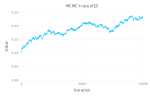

In [132]:
plotTraceMCMC(chain, "ξ5")